In [174]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import export_text
import xgboost as xgb
import matplotlib.pyplot as plt

In [71]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [72]:
df = df[df['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]
df['total_bedrooms'] = df['total_bedrooms'].fillna(0)

In [73]:
df['median_house_value'] = np.log1p(df['median_house_value'])

In [74]:
df_train_val, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_val, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [88]:
features = ['latitude',
        'longitude',
        'housing_median_age',
        'total_rooms',
        'total_bedrooms',
        'population',
        'households',
        "median_income",
        "ocean_proximity"]

In [89]:
X_train, y_train = df_train[features], df_train['median_house_value']
X_val, y_val = df_val[features], df_val['median_house_value']
X_test, y_test = df_test[features], df_test['median_house_value']

In [90]:
v = DictVectorizer(sparse=True)
train_dicts = v.fit_transform(X_train.to_dict(orient='records'))
val_dicts = v.transform(X_val.to_dict(orient='records'))
test_dicts = v.transform(X_test.to_dict(orient='records'))

# Question 1

In [91]:
rf_reg = DecisionTreeRegressor(max_depth=1)
rf_reg.fit(train_dicts, y_train) 

DecisionTreeRegressor(max_depth=1)

In [92]:
print(export_text(rf_reg, feature_names=v.feature_names_))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



# Question 2

In [96]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(train_dicts, y_train)
y_predicted = rf.predict(val_dicts)
mean_squared_error(y_val, y_predicted, squared=False)

0.24527740463893763

# Question 3

In [118]:
ls = []

for n_estimators in np.arange(10,201,10):
    rf = RandomForestRegressor(n_estimators, random_state=1, n_jobs=-1)
    rf.fit(train_dicts, y_train)
    y_predicted = rf.predict(val_dicts)

    ls.append([n_estimators, mean_squared_error(y_val, y_predicted, squared=False)])

df_score = pd.DataFrame(data=ls,columns=['n_estimators', 'rmse'])

In [123]:
df_score.sort_values(by='rmse', ascending=False)

,n_estimators,rmse
0,10,0.245277
1,20,0.239041
2,30,0.236995
3,40,0.235509
4,50,0.235021
7,80,0.234721
5,60,0.234584
8,90,0.234512
6,70,0.234466
9,100,0.234308


# Question 4

In [127]:
ls = []

for max_depth in [10,15,20,25]:
    for n_estimators in np.arange(10,201,10):
        rf = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators, random_state=1, n_jobs=-1)
        rf.fit(train_dicts, y_train)
        y_predicted = rf.predict(val_dicts)

        ls.append([
            max_depth, n_estimators, mean_squared_error(y_val, y_predicted, squared=False)
        ])

df_score = pd.DataFrame(data=ls,columns=['max_depth', 'n_estimators', 'rmse'])

In [129]:
df_score.sort_values(by='rmse', ascending=False)

,max_depth,n_estimators,rmse
0,10,10,0.250677
1,10,20,0.247672
2,10,30,0.246434
20,15,10,0.245772
7,10,80,0.245640
...,...,...,...
73,25,140,0.233618
77,25,180,0.233606
74,25,150,0.233515
76,25,170,0.233433


# Question 5

In [143]:
rf = RandomForestRegressor(max_depth=20, n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(train_dicts, y_train)

pd.DataFrame(data=[*zip(features, rf.feature_importances_)], columns=['feature', 'feature_importance'])\
    .sort_values(by='feature_importance', ascending=False)

,feature,feature_importance
4,total_bedrooms,0.335611
5,population,0.292473
2,housing_median_age,0.102007
3,total_rooms,0.086244
6,households,0.073806
1,longitude,0.030317
7,median_income,0.027136
8,ocean_proximity,0.015852
0,latitude,0.015136


# Question 6

In [144]:
!pip install xgboost

     --------------------------------------- 99.7/99.7 MB 13.9 MB/s eta 0:00:00


In [171]:
scores = {}

In [172]:
dtrain = xgb.DMatrix(train_dicts, label=y_train)
dval = xgb.DMatrix(val_dicts, label=y_val)

watchlist = [(dtrain,'train'), (dval,'eval')]
progress = dict()
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

bst = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist
                  ,  evals_result=progress)

scores['eta=0.3'] = progress['eval']['rmse']

[0]	train-rmse:0.44350	eval-rmse:0.44250
[5]	train-rmse:0.25338	eval-rmse:0.27463
[10]	train-rmse:0.21444	eval-rmse:0.25179
[15]	train-rmse:0.19858	eval-rmse:0.24522


[20]	train-rmse:0.18524	eval-rmse:0.23978
[25]	train-rmse:0.17757	eval-rmse:0.23830
[30]	train-rmse:0.16888	eval-rmse:0.23570
[35]	train-rmse:0.16113	eval-rmse:0.23416
[40]	train-rmse:0.15542	eval-rmse:0.23318
[45]	train-rmse:0.14941	eval-rmse:0.23190
[50]	train-rmse:0.14536	eval-rmse:0.23225
[55]	train-rmse:0.14150	eval-rmse:0.23197
[60]	train-rmse:0.13719	eval-rmse:0.23139
[65]	train-rmse:0.13259	eval-rmse:0.23158
[70]	train-rmse:0.12943	eval-rmse:0.23068
[75]	train-rmse:0.12555	eval-rmse:0.23039
[80]	train-rmse:0.12192	eval-rmse:0.22886
[85]	train-rmse:0.11854	eval-rmse:0.22888
[90]	train-rmse:0.11496	eval-rmse:0.22861
[95]	train-rmse:0.11211	eval-rmse:0.22908
[99]	train-rmse:0.10989	eval-rmse:0.22862


In [173]:
progress = dict()
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

bst = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist
                  ,  evals_result=progress)

scores['eta=0.1'] = progress['eval']['rmse']

[0]	train-rmse:0.52449	eval-rmse:0.52045
[5]	train-rmse:0.37822	eval-rmse:0.38151
[10]	train-rmse:0.30326	eval-rmse:0.31427
[15]	train-rmse:0.26538	eval-rmse:0.28380


[20]	train-rmse:0.24512	eval-rmse:0.26882
[25]	train-rmse:0.23026	eval-rmse:0.25997
[30]	train-rmse:0.21887	eval-rmse:0.25266
[35]	train-rmse:0.21020	eval-rmse:0.24826
[40]	train-rmse:0.20392	eval-rmse:0.24539
[45]	train-rmse:0.19814	eval-rmse:0.24293
[50]	train-rmse:0.19215	eval-rmse:0.24020
[55]	train-rmse:0.18809	eval-rmse:0.23878
[60]	train-rmse:0.18457	eval-rmse:0.23791
[65]	train-rmse:0.18063	eval-rmse:0.23698
[70]	train-rmse:0.17741	eval-rmse:0.23622
[75]	train-rmse:0.17468	eval-rmse:0.23510
[80]	train-rmse:0.17242	eval-rmse:0.23453
[85]	train-rmse:0.17014	eval-rmse:0.23404
[90]	train-rmse:0.16797	eval-rmse:0.23332
[95]	train-rmse:0.16562	eval-rmse:0.23276
[99]	train-rmse:0.16323	eval-rmse:0.23209


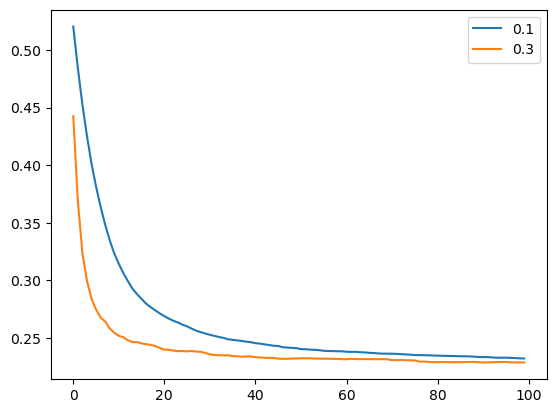

In [176]:
plt.plot(scores['eta=0.1'],
        label='0.1')
plt.plot(scores['eta=0.3'],
        label='0.3')
plt.legend()
plt.show()

# RMSE best score. eta=0.3